# NDReg

## Preface
I am completing this algorithms MD to the extent of my current knowledge. I will be meeting with Kwame on Tuesday 1/17 in order to fill in the gaps in my knowledge and obtain a more comprehensive understanding of the algorithm. 

## Algorithm
### Description
NDReg is an algorithm designed to calculate one or more coordinate transformations with the goal of aligning two images of the same scene. For our specific application, NDreg will be used to track specific synapses over time, such that stochastic statistics can be generated about the subject's synaptic activity.

### Inputs
- inImg_ds -> The image two be aligned
- refImage_ds -> The image which inImg_ds is being aligned to
- iterations -> The number of iterations to run the algorithm
- useMI -> Whether or not to use MI (Not sure exactly what MI is, defaults to True)
- verbose -> Whether or not to print progress and debug data

### Outputs
- The parameters of an affine transform that maps the inImg_ds to the refImage_ds

### Function

In [3]:
####################################################
###PSEUDOCODE WILL GO HERE ONCE I MEET WITH KWAME###
####################################################

### Analysis
#### Qualitative Visualizations
I will display the input and base image to be passed to the register function, and the result of applying the register function's output to the input image.

#### Quantitative Score
I will use the following loss function (sum of squared errors) to evaluate the success of the algorithm:
$\Sigma_{voxels}L_2(inputImage[voxel] - baseImage[voxel])$

#### Summary Score
I will use the average percent reduction in squared error over a series of tests to summarize the quantitative performance of the algorithm.

#### Null Comparison
I will compare the results of the register function to a function which generates and applies a random affine transformation in order to demonstrate how well the algorithm performes compared to random guessing.



### Write Code

In [14]:
import sys
sys.path.insert(0, '../../../ndreg/')
import ndreg

def register(inImg, baseImg):
    return ndreg.imgAffineComposite(inImg,
                              baseImg,
                              iterations=200,
                              useMI=True,
                              verbose=False)

## Simulation
### Functionality Testing
NDReg functionality tests will be performed in order to verify that the register funciton is working as expected.

#### 1. Generate Data

In [23]:
refImg = ndreg.imgDownload('ara_ccf2')
refAnnoImg = ndreg.imgDownload('ara_ccf2', channel="annotation")
inImg = ndreg.imgDownload('eacker01', 'r', 5)

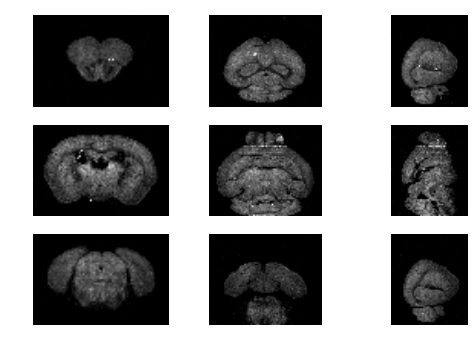

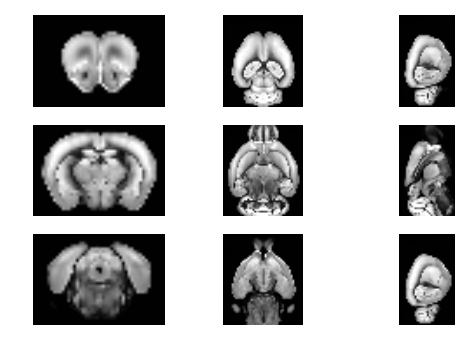

In [31]:
#reorient and rescale the test image
inImgReor = ndreg.imgReorient(inImg, 'lsp', 'rsa')
inImg_ds = ndreg.imgResample(inImgReor, spacing=[.25, .25, .25])
refImg_ds = ndreg.imgResample(refImg, spacing=[.25, .25, .25])

#display the images to be registered
ndreg.imgShow(inImg_ds, vmax=10000)
ndreg.imgShow(refImg_ds, vmax=500)

#### 2. Generate Results

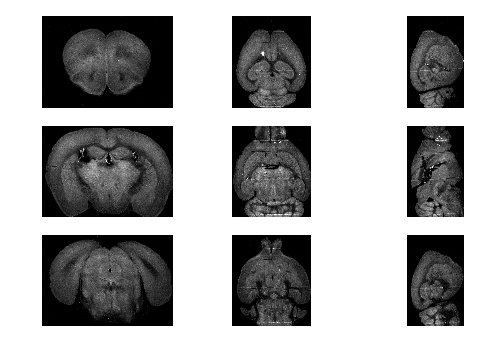

In [39]:
affine = register(inImg_ds, refImg_ds)
resultImage = ndreg.imgApplyAffine(inImgReor,
                                   affine,
                                   size=refImg.GetSize(),
                                   spacing=refImg.GetSpacing())
ndreg.imgShow(resultImage, vmax=10000)

#### 3. Analyze Results
The results of this functionality test are consistent with those of the NDReg documentation. I can now proceed to the validation testing phase. 

### Validation Testing
#### 1. Generate Data
The following code will generate two 100x100x100 volumes randomly populated with synapses and noise modeling that of the real world data, and then apply a random affine transformation to one of the volumes. The volumes will then be run thorugh the register algorithm in order to attemt to align them again.

In [40]:
import numpy as np
from random import randrange as rand
from random import uniform as floatRand

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)               
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                        
                if valid:
                    toPopulate.append(curPoint)
            
    return set(toPopulate)                       

                    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
      
    #convert numpy array to itk image
    itkVolume = itk.GetImageFromArray(noiseVolume)
    
    #perform a random affine transform to generate the second volume
    transform = [floatRand(-2., 2.) for _ in range(12)]
    affineVolume = ndreg.imgApplyAffine(itkVolume, transform)
    
    return itkVolume, affineVolume